In [ ]:
import pickle
from typing import Any, Dict, Tuple
import shap

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

from implicit.cpu.als import AlternatingLeastSquares
from rectools.models import LightFMWrapperModel
from lightfm import LightFM

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from lightgbm import LGBMRanker
import requests
import rectools
from rectools import Columns
from lightfm.data import Dataset
from rectools.dataset import Interactions
from rectools.model_selection import TimeRangeSplitter
from rectools.metrics import MAP, NDCG, Precision, Recall, MeanInvUserFreq, Serendipity, calc_metrics
from rectools.tools.ann import UserToItemAnnRecommender

# Preparing data

In [ ]:
interactions = pd.read_csv('../data_original/interactions.csv')
users = pd.read_csv('../data_original/users.csv')
items = pd.read_csv('../data_original/items.csv')

In [ ]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    },
    inplace=True,
)
# Меняем тип данных
interactions['datetime'] = interactions['datetime'].astype(np.datetime64)

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions.head(10)

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


In [ ]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


# Train val test data split

In [ ]:

ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7))
]

train_size = 0.7
val_size = 0.15
test_size = 0.15



train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

In [ ]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
    # 'user_id',
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding['income'], users['income'].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [ ]:
base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

In [ ]:
base_users = base_models_data[Columns.User].unique()
base_items = base_models_data[Columns.Item].unique()

In [ ]:
lightfm_dataset = Dataset()
lightfm_user_ids = base_models_data['user_id'].unique()
lightfm_item_ids = base_models_data['item_id'].unique()
lightfm_dataset.fit(lightfm_user_ids, lightfm_item_ids)

In [ ]:
from rectools.dataset import Dataset

In [ ]:
dataset = Dataset.construct(
    interactions_df=base_models_data,
    user_features_df=None,
    item_features_df=None,
)

In [ ]:

interactions_matrix, weights_matrix = lightfm_dataset.build_interactions(
    zip(*base_models_data[['user_id', 'item_id', Columns.Weight]].values.T)
)
weights_matrix = weights_matrix.tocsr()

# Обучаем модель первого уровня

I chose to use LightFMWrapperModel as first level model

In [ ]:
K_RECOS = 10
RANDOM_STATE = 42
NUM_THREADS = 16
N_FACTORS = (32,)
N_EPOCHS = 1 # Lightfm
USER_ALPHA = 0 # Lightfm
ITEM_ALPHA = 0 # Lightfm
LEARNING_RATE = 0.05 # Lightfm

In [ ]:
LightFM_model = LightFMWrapperModel(
            LightFM(
                no_components=46,
                loss='warp',
                random_state=RANDOM_STATE,
                learning_rate=0.02592156907197242
            ),
            epochs=10,
            num_threads=NUM_THREADS,
        )

LightFM_model.fit(dataset)



In [ ]:
with open("LightFM_model.pkl", "wb") as file:
    LightFM_model = pickle.dump(LightFM_model,file)

In [ ]:
with open("LightFM_model.pkl", "rb") as file:
    LightFM_model = pickle.load(file)

In [ ]:
print(dataset.user_id_map)
print(lightfm_user_ids)


IdMap(external_ids=array([1016458,  884009,  203219, ...,  974756,  648596,  697262]))
[176549 699317 656683 ... 881344 882138 805174]


In [ ]:
candidates = LightFM_model.recommend(users=base_users, dataset=dataset, k=100, filter_viewed=False)

In [ ]:
candidates.to_csv('candidates.csv', index=False)

In [ ]:
candidates = pd.read_csv('candidates.csv')

In [ ]:
candidates.head(10)

,user_id,item_id,score,rank
0,176549,7571,-392.39517,1
1,176549,9728,-392.41702,2
2,176549,13865,-392.43103,3
3,176549,12995,-392.48624,4
4,176549,13018,-392.59128,5
5,176549,12173,-392.75840,6
6,176549,16166,-392.78128,7
7,176549,849,-392.86493,8
8,176549,4436,-392.91583,9
9,176549,15464,-392.91650,10


# Раcчёт метрик


In [ ]:
# Считаем метрики
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k = 10),
        'map@10': MAP(k = 10),
        'Precision@10': Precision(k = 10),
        'recall@10': Recall(k = 10),
        'novelty@10': MeanInvUserFreq(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ),
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics['lfm'] = calc_metrics_(candidates, 'rank')
models_metrics['lfm']

{'Precision@10': 0.009642485746046545,
 'recall@10': 0.05051626930866677,
 'ndcg@10': 0.01122314611174527,
 'map@10': 0.020629908264137426,
 'novelty@10': 3.8758360758253043}

In [ ]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомы и таргеты

def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df['user_id'].isin(user_list)],
        candidates_df[candidates_df['user_id'].isin(user_list)],
        how='outer',  # right ?
        on=['user_id', 'item_id']
    )
    # Проставляем дефолтные значения интеракций
    min_score: float =  df['score'].min() - 0.01
    max_rank: int = df['rank'].max() + 1  # 101

    default_values = {
        'lfm_score': min_score, 'rank': max_rank,
        # Важно использовате те же дефолтные значения для интеракций,
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)

    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

ranker_train = users_filter(train_users, candidates, base_models_data)
ranker_val = users_filter(val_users, candidates, base_models_data)
ranker_test = users_filter(test_users, candidates, base_models_data)

ranker_train.head(3)

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


,user_id,item_id,datetime,total_dur,weight,score,rank
2868742,21,24,2021-07-01,0.0,0.0,-404.55760,86.0
2868687,21,101,2021-07-01,0.0,0.0,-403.95187,28.0
2868673,21,142,2021-07-01,0.0,0.0,-403.46045,10.0


In [ ]:
models_metrics['listwise'] = calc_metrics_(ranker_test, 'listwise_rank')
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise', 'listwise_hybrid']]

Expected integer dtype of 'rank' column in 'reco' dataframe.
Expected integer dtype of 'rank' column in 'reco' dataframe.


,listwise,listwise_hybrid
Precision@10,0.009642,0.009642
recall@10,0.050516,0.050516
ndcg@10,0.011223,0.011223
map@10,0.020630,0.020630
novelty@10,3.875836,3.875836


In [ ]:
models_metrics['listwise'] = calc_metrics_(ranker_test, 'listwise_rank')
pd.DataFrame(models_metrics)

Expected integer dtype of 'rank' column in 'reco' dataframe.


,lfm,listwise,listwise_hybrid
Precision@10,0.009642,0.009642,0.009642
recall@10,0.050516,0.050516,0.050516
ndcg@10,0.011223,0.011223,0.011223
map@10,0.020630,0.020630,0.020630
novelty@10,3.875836,3.875836,3.875836


# Second level model

In [ ]:
def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [ ]:
# Добавим таргет посложнее

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,score,rank,target_ranker
2868742,21,24,2021-07-01,0.0,0.0,-404.55760,86.0,0
2868687,21,101,2021-07-01,0.0,0.0,-403.95187,28.0,0
2868673,21,142,2021-07-01,0.0,0.0,-403.46045,10.0,0


In [ ]:
ranker_train.columns

Index(['user_id', 'item_id', 'datetime', 'total_dur', 'weight', 'score',
       'rank', 'target_ranker'],
      dtype='object')

In [ ]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    'score', 'rank','target_ranker'
]
# Из них категориальные:
cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type', 'for_kids', 'studios',
]

In [ ]:
early_stopping_rounds = 32
params = {
    'objective': 'lambdarank',  # lambdarank, оптимизирующий ndcg
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'early_stopping_rounds': early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    'verbose': early_stopping_rounds // 8,  # период вывода метрик
    'random_state': 42,
}
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'feature_name': cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.308813
[LightGBM] [Debug] init for col-wise cost 0.000022 seconds, init for row-wise cost 0.242445 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 5824630, number of used features: 3
[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 4
Training until va

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.25,
           max_depth=4, min_child_samples=100, n_estimators=10000,
           num_leaves=10, objective='lambdarank', random_state=42, reg_lambda=1,
           verbose=4)

In [ ]:
with open('listwise_model.pkl', 'wb') as f:
  pickle.dump(listwise_model, f)

In [ ]:
with open("listwise_model.pkl", "rb") as file:
    listwise_model = pickle.load(file)

In [ ]:
listwise_model.best_score_['valid_0']

OrderedDict([('ndcg@3', 1.0), ('ndcg@5', 1.0), ('ndcg@10', 1.0)])

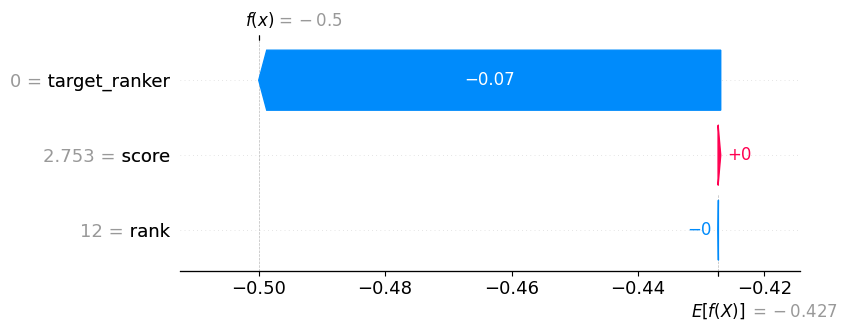

In [ ]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

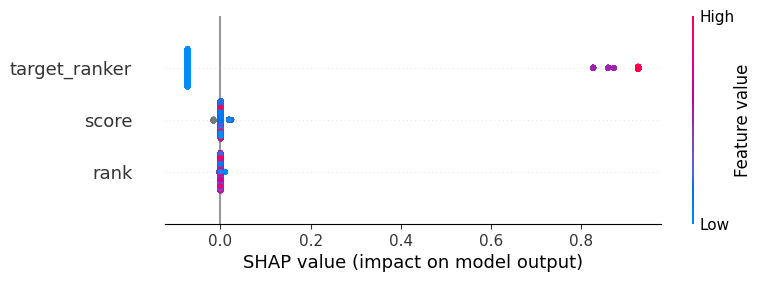

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

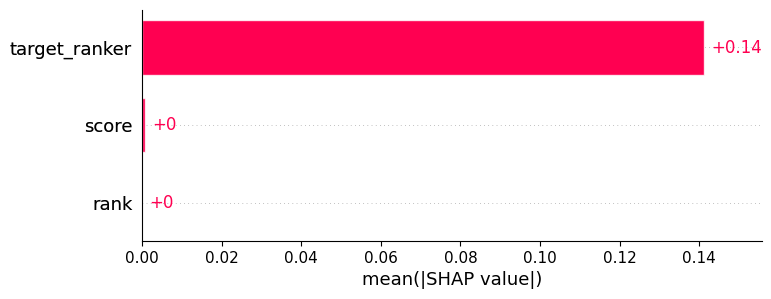

In [ ]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [ ]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f'{name}_score'] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    return df

In [ ]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'target')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,score,rank,target_ranker,listwise_score,listwise_rank,target_score,target_rank
72130,3,3734,2021-07-22,5377.0,99.0,3.152552,7.0,2,0.499984,1,0.499984,1
1103531,3,142,2021-07-01,0.0,0.0,2.752505,12.0,0,-0.499988,2,-0.499988,2
1103574,3,846,2021-07-01,0.0,0.0,1.671950,55.0,0,-0.499988,3,-0.499988,3


In [ ]:
models_metrics['target'] = calc_metrics_(ranker_test, 'target')
pd.DataFrame(models_metrics)

Expected integer dtype of 'rank' column in 'reco' dataframe.


,lfm,listwise,listwise_hybrid,target
Precision@10,0.009642,0.009642,0.009642,0.009642
recall@10,0.050516,0.050516,0.050516,0.050516
ndcg@10,0.011223,0.011223,0.011223,0.011223
map@10,0.020630,0.020630,0.020630,0.020630
novelty@10,3.875836,3.875836,3.875836,3.875836
